In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_alfa_svm_db.csv'))
print(df.shape)
print(df.columns)

(1350, 38)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')


In [5]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
print(len(COLS_CM))

COL_Y = 'Test.Poison'
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

28


In [6]:
N_ITER_SEARCH = 200
N_FOLD = 5
THRESHOLD = 0.00

In [7]:
def get_pivot_table(df, positive_threshold=THRESHOLD):
    # Step 0: Add difficulty levels
    df = df.copy()
    df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
    cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
    df['Difficulty'] = df['Difficulty'].astype(cat_type)

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[df['Rate'] == 0].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        idx_train = df[df['Data.Base'].isin(data_train)].index
        idx_test = df[df['Data.Base'].isin(data_test)].index
        assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Step 3: Find threshold
    # y_true_ = (df['Rate'] > positive_threshold).astype(int)
    # y_score_ = df['Train.Poison'] - df['Prediction']
    # fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
    # idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
    # threshold = thresholds[idx_t]

    # df_ = df[(df['Difficulty'] != 'Hard') & (df['Rate'] == 0)]
    df_ = df[(df['Difficulty'] == 'Normal') & (df['Rate'] == 0)]
    # df_ = df[df['Rate'] == 0]
    dif_00 = (df_['Train.Poison'] - df_['Prediction'])
    threshold = np.quantile(dif_00, 0.95)

    print(f'threshold: {threshold}')

    # Step 4: Populate pivot table
    results = (df['Train.Poison'] - df['Prediction']) >= threshold
    df_ = df[['Difficulty', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    df_pivot
    return df_pivot, threshold

In [8]:
pivot_tables = []

for workspace in [f'diva_{i:02d}' for i in range(1, 4)]:
    print(workspace)

    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth', f'synth_{att}_db.csv'))

        tab, _ = get_pivot_table(df_, positive_threshold=THRESHOLD)
        tab.to_csv(os.path.join(path_output, f'synth_pivot_{workspace}_{att}.csv'))

        tab = tab.reset_index()
        pivot_tables.append(tab)
        
pivot_1 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_1

diva_01
alpha=0.000100
threshold: 0.3401435669537158
alpha=0.017500
threshold: 0.2966096587464213
diva_02
alpha=0.051900
threshold: 0.34525750428811053
alpha=0.000400
threshold: 0.30995451381697836
diva_03
alpha=0.074300
threshold: 0.3234441202265951
alpha=0.012000
threshold: 0.3183874981426922


Dataset Difficulty,Easy,Normal,Hard
Poisoning Rate,,,
0.00,0.0,3.0,21.0
0.05,0.0,8.0,31.0
0.10,1.0,22.0,37.0
0.15,2.0,27.0,40.0
0.20,12.0,33.0,41.0
0.25,16.0,36.0,42.0
0.30,25.0,38.0,44.0
0.35,25.0,38.0,44.0
0.40,28.0,39.0,46.0


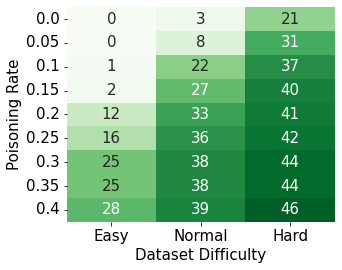

In [9]:
FONTSIZE = 15
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.heatmap(pivot_1, ax=ax, annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=50, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
def get_pivot_noise(df, train_noise_lvl=0):
    # Read noise rate from data's name
    noise_rate = df['Data'].apply(lambda x: float(x.split('_')[6][2:]))
    df['Noise.Rate'] = noise_rate

    # Remove noise rate from data's name
    df['Data.Base'] = df['Data.Base'].apply(lambda x: '_'.join(list(np.delete(x.split('_'), -2))))

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    counter = 0
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        df_noise_threshold = df[df['Noise.Rate'] <= train_noise_lvl]
        idx_train = df_noise_threshold[df_noise_threshold['Data.Base'].isin(data_train)].index

        idx_test = df[df['Data.Base'].isin(data_test)].index
        counter += len(idx_test)

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)
    assert counter == df.shape[0], f'{counter} != {df.shape[0]}'

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Set Threshold
    df_ = df[(df['Rate'] == 0) & (df['Noise.Rate'] <=train_noise_lvl)]
    dif_00 = (df_['Train.Poison'] - df_['Prediction'])
    threshold = np.quantile(dif_00, 0.95)
    print(f'threshold: {threshold}')

    results = (df['Train.Poison'] - df['Prediction']) > threshold
    df_ = df[['Noise.Rate', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Noise.Rate':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
    return df_pivot

In [11]:
pivot_tables_noise = []
att = 'falfa_nn'

for workspace in [f'diva_{i:02d}' for i in range(1, 4)]:
    print(workspace)
    df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth_noisy', f'synth_{att}_db.csv'))

    tab = get_pivot_noise(df_)
    tab.to_csv(os.path.join(path_output, f'synth_noise_pivot_{workspace}_{att}.csv'))

    tab = tab.reset_index()
    pivot_tables_noise.append(tab)

pivot_2 = pd.concat(pivot_tables_noise, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_2

diva_01
alpha=0.008500
threshold: 0.3480991397671748
diva_02
alpha=0.003500
threshold: 0.3143755054945906
diva_03
alpha=0.002300
threshold: 0.33959619926712703


Noise Label Rate,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4
Poisoning Rate,,,,,,,,,
0.00,3.0,6.0,9.0,16.0,18.0,22.0,28.0,30.0,30.0
0.05,9.0,13.0,16.0,22.0,25.0,29.0,31.0,30.0,31.0
0.10,19.0,24.0,27.0,31.0,30.0,29.0,30.0,31.0,30.0
0.15,22.0,27.0,31.0,33.0,33.0,33.0,34.0,34.0,34.0
0.20,30.0,32.0,31.0,33.0,33.0,34.0,34.0,33.0,34.0
0.25,27.0,34.0,34.0,34.0,35.0,36.0,35.0,37.0,37.0
0.30,34.0,35.0,36.0,36.0,37.0,36.0,36.0,38.0,36.0
0.35,32.0,34.0,36.0,34.0,37.0,37.0,39.0,37.0,38.0
0.40,33.0,34.0,39.0,39.0,39.0,37.0,40.0,38.0,36.0


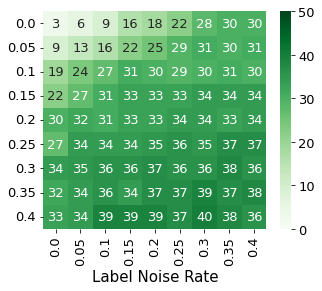

In [12]:
FONTSIZE = 13
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.heatmap(pivot_2, ax=ax, annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=50)
plt.yticks(rotation=0)
plt.xlabel('Label Noise Rate', fontsize=FONTSIZE+2)
# plt.ylabel('Poisoning Rate', fontsize=FONTSIZE+2)
plt.ylabel('')
plt.show()

Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap.svg


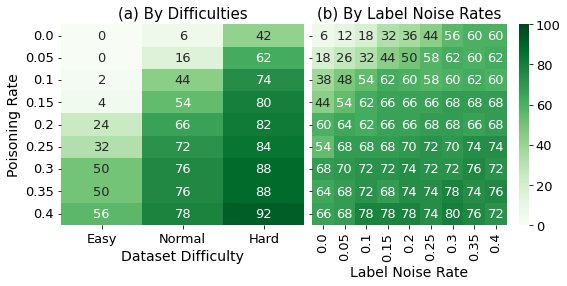

In [13]:
FONTSIZE = 13
FIGSIZE = (8, 4)
X_LABELS = ['Dataset Difficulty', 'Label Noise Rate']
TITLES = ['(a) By Difficulties', '(b) By Label Noise Rates']

plt.rcParams["font.size"] = FONTSIZE
fig, axes = plt.subplots(1, 2, sharey=True, figsize=FIGSIZE)

pivot_1 = pivot_1 * 2
sns.heatmap(pivot_1, ax=axes[0], annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=100, cbar=False)
axes[0].set_ylabel('Poisoning Rate', fontsize=FONTSIZE+1)

pivot_2 = pivot_2 * 2
sns.heatmap(pivot_2, ax=axes[1], annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=100)
axes[1].set_ylabel('')

for i, ax in enumerate(axes):
    ax.set_xlabel(X_LABELS[i], fontsize=FONTSIZE+1)
    ax.set_title(TITLES[i], fontsize=FONTSIZE+2)

plt.tight_layout(pad=0.6)
plot_heatmap = os.path.join(path_output, 'synth_heatmap.svg')
plt.savefig(plot_heatmap, dpi=300)
print(f'Save to: {plot_heatmap}')